# Ateísmo e COVID-19: Países menos religiosos respondem melhor? - Um estudo preliminar


Que as religiões trazem conforto e estão ligadas a ações sociais nas mais diversas formas é inegável.


Entretanto, frequentemente as atividades religiosas são acompanhadas por dogmas, que em casos colidem (direta ou indiretamente) com os estudos lógico-científicos. 

Será que, então, nações com populações menos religiosas reagiriam diferente ao COVID-19?


O trabalho visa avaliar brevemente as diferenças na resposta a COVID-19 levando em consideração essa variável.


Dados de irreligião e testagem por milhão de habitantes foram obtidos das páginas Wikipédia abaixo. 
* Dados sobre religião: https://en.wikipedia.org/w/index.php?title=List_of_countries_by_irreligion&oldid=946799645 (25/04/2020)
* Dados sobre testagem para COVID-19 https://en.wikipedia.org/w/index.php?title=COVID-19_testing&oldid=952911161#Virus_testing_statistics_by_country (25/04/2020)



In [1]:

# Obtendo as páginas da Wikipédia em formato HTML

import urllib.request

irreligion_article_url = "https://en.wikipedia.org/w/index.php?title=List_of_countries_by_irreligion&oldid=946799645"


req = urllib.request.urlopen(irreligion_article_url)
article = req.read().decode()

with open('irreligion_wikipedia.html', 'w') as fo:
    fo.write(article)

covid_testing_url = "https://en.wikipedia.org/w/index.php?title=COVID-19_testing&oldid=952911161#Virus_testing_statistics_by_country"


req = urllib.request.urlopen(covid_testing_url)
article = req.read().decode()

with open('covid_testing_wikipedia.html', 'w') as fo:
    fo.write(article)
  
    
    

In [2]:
# Extraindo as tabelas de interesse


## Primeiro para a irreligião 


from bs4 import BeautifulSoup

# Load article, turn into soup and get the <table>s.
article = open('irreligion_wikipedia.html').read()
soup = BeautifulSoup(article, 'html.parser')
tables = soup.find_all('table', class_='sortable')

# Search through the tables for the one with the headings we want.
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[0] == 'Country or region':
        break

# Extract the columns we want and write to a semicolon-delimited text file.
with open('irreligion_wikipedia_table.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        if not tds:
            continue
        country, irreligion = [td.text.strip() for td in tds[:2]]
        # Wikipedia does something funny with country names containing
        # accented characters: extract the correct string form.
        if '!' in country:
            country = country[country.index('!')+1:]
        print('; '.join([country, irreligion]), file=fo)

In [3]:
## Agora para os testes de covid-19


# Load article, turn into soup and get the <table>s.
article = open('covid_testing_wikipedia.html').read()
soup = BeautifulSoup(article, 'html.parser')
tables = soup.find_all('table', class_='sortable')

# Search through the tables for the one with the headings we want.
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[0] == 'Country':
        break

# Extract the columns we want and write to a semicolon-delimited text file.
with open('covid_testing_table.txt', 'w') as fo:
    for tr in table.find_all('tr'):
        tds = tr.find_all('td')
        ths = tr.find_all('th')
        if not tds:
            continue
        for th in ths:
            country = ths[0].text.strip()
        if country == "Vietnam": break
        tests_by_million_people = tds[4].text.strip()
        # Wikipedia does something funny with country names containing
        # accented characters: extract the correct string form.
        if '!' in country:
            country = country[country.index('!')+1:]
        print('; '.join([country, tests_by_million_people]), file=fo)

In [4]:
import pandas as pd
irreligion_by_country = pd.read_csv("irreligion_wikipedia_table.txt", header = None, sep = ";", names=["country", "irreligion_proportion"])
tests_per_million_by_country = pd.read_csv("covid_testing_table.txt", header = None, sep = ";", names=["country", "tests_per_million"])

In [5]:
import re

tests_per_million_by_country["country"] = [re.sub(r"\[.\]", "", country).strip() for country in tests_per_million_by_country["country"]]


In [6]:
import re

irreligion_by_country["country"] = [re.sub(r" \(details\)", "", country).strip() for country in irreligion_by_country["country"]]


In [7]:
import numpy as np



irreligion_and_tests_df = irreligion_by_country.merge(tests_per_million_by_country, on = 'country')
irreligion_and_tests_df = irreligion_and_tests_df[irreligion_and_tests_df["irreligion_proportion"] != " "]
irreligion_and_tests_df = irreligion_and_tests_df.dropna(axis = "columns")


In [8]:
def get_proportion(percentage_string):
    number_to_be_divided = float(percentage_string.strip("%"))
    proportion = number_to_be_divided/100
    return(proportion)


irreligion_and_tests_df["irreligion_proportion"] = [get_proportion(percentage) for percentage in irreligion_and_tests_df["irreligion_proportion"] ]




irreligion_and_tests_df["tests_per_million"] = [int(test_number.replace(",", "")) for test_number in irreligion_and_tests_df["tests_per_million"] ]


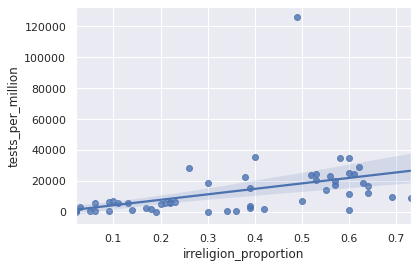

In [9]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


ax = sns.regplot(x="irreligion_proportion", y="tests_per_million", data=irreligion_and_tests_df)
ax.set(xlabel='Proporção de pessoas não religiosas', ylabel='T')

In [10]:
len(irreligion_and_tests_df["tests_per_million"])

irreligion_and_tests_df["country"][irreligion_and_tests_df["tests_per_million"] == 126204]

# O país com mais testes é a islândia, que tem uma população pequena e testa muito

24    Iceland
Name: country, dtype: object

In [11]:
from scipy.stats import spearmanr

spearmanr(irreligion_and_tests_df["irreligion_proportion"], irreligion_and_tests_df["tests_per_million"])

SpearmanrResult(correlation=0.6349349408735319, pvalue=4.2924622978422285e-07)

# Breve discussão e conclusão do trabalho:

Com uma correlação positiva moderada de 0.63 e um valor p de 0,0000004, dá para afirmar que há uma correlação entre irreligiosidade e intensidade da resposta ao COVID-19. 

O valor p indica, grosso modo, a proporção de vezes que você veria uma correlação de 0.63 ou maior se os valores fossem aleatórios para as duas coisas comparadas. 

Correlação não siginifca, causalidade, entretanto, e este é apenas um resultado preliminar. 

O resultado observado indica que o tema vale ser explorado com maior profundidade para compreender melhor as respostas nacionais à pandemia. 